Some $\LaTeX$ macros:

$$
\newcommand{\dd}{\mathrm{d}}
\newcommand{\diff}[2]{\frac{\dd #1}{\dd #2}}
$$

In [1]:
%pylab inline
%config InlineBackend.figure_format = 'retina'
import pystan
import seaborn as sns
import scipy.special as sp

Populating the interactive namespace from numpy and matplotlib


In [2]:
sns.set_style('ticks')
sns.set_context('notebook')
sns.set_palette('colorblind')

Here is a simple model that illustrates (inspired by Malmquist's classic work on the luminosity corrections due to selection effects in populations of stars):

The Luminosity function of galaxies is typically modelled by a Schechter function:
$$
\diff{N}{L} = \frac{N}{L_*^{1+\alpha} \Gamma\left(1+\alpha\right)} L^\alpha \exp\left[ - \frac{L}{L_*}\right]
$$
with $\alpha > -1$ and $L_*>0$ parameters controlling the shape of the distribution and $N$ the overall normalisation.

Suppose we can typically measure fluxes (and therefore luminosities) with $\sigma_L \simeq 5\%$ uncertainty:
$$
p\left( L_\mathrm{obs} \mid L \right) = \frac{1}{\sigma_L L_\mathrm{obs} \sqrt{2\pi}} \exp\left[ - \frac{1}{2} \left(\frac{\log L - \log L_\mathrm{obs}}{5\%} \right)^2\right].
$$

We want to use a flux-limited survey to infer the galaxy luminosity function.  Assume a Euclidean universe, so 
$$
P_\mathrm{det} \left( L_\mathrm{obs} \right) = \begin{cases}
1 & \frac{L_\mathrm{obs}}{4 \pi z^2} > F_\mathrm{th} \\
0 & \mathrm{otherwise}
\end{cases}
$$
To make things a bit more efficient, we are going to assume that galaxies are distributed uniformly in $z$, rather than volumetrically (this will just reduce the number of low-flux galaxies we need to track in the integral, which will make the computation more efficient).

We will assume that the true values of the parameters are $L_* = 1$, $\alpha = -0.5$, and choose a flux threshold so that we can just observe a $L_*$ galaxy at $z = 1$: $F_\mathrm{th} = \frac{1}{4\pi}$.  The code below draws random glaxies according to these recipes:

In [3]:
def schechter(L, alpha, Lstar):
    return L**alpha*exp(-L/Lstar)/(Lstar**(1+alpha)*sp.gamma(1+alpha))

In [4]:
def draw_redshift(zmax, size=1):
    return zmax*random.uniform(size=size)

In [5]:
def draw_luminosity(alpha, Lstar, size=1):
    xs = (1 - random.uniform(size=size))
    return Lstar*sp.gammaincinv(1+alpha, xs)

In [6]:
def draw_lobs(L, size=1):
    return exp(log(L) + 0.05*randn(size))

In [7]:
def draw_survey(N, alpha, Lstar, Fth, zmax):
    n = random.poisson(N)
    
    Ls = draw_luminosity(alpha, Lstar, size=n)
    zs = draw_redshift(zmax, size=n)
    
    Lobs = draw_lobs(Ls, size=n)
    
    Fobs = Lobs / (4*pi*zs*zs)
    
    sel = Fobs > Fth
    
    print(np.max(zs[sel]))
    
    return Lobs[sel]

In [11]:
Ls = draw_survey(1000, -0.5, 1.0, 1/(4*pi), 3)

2.09129663606


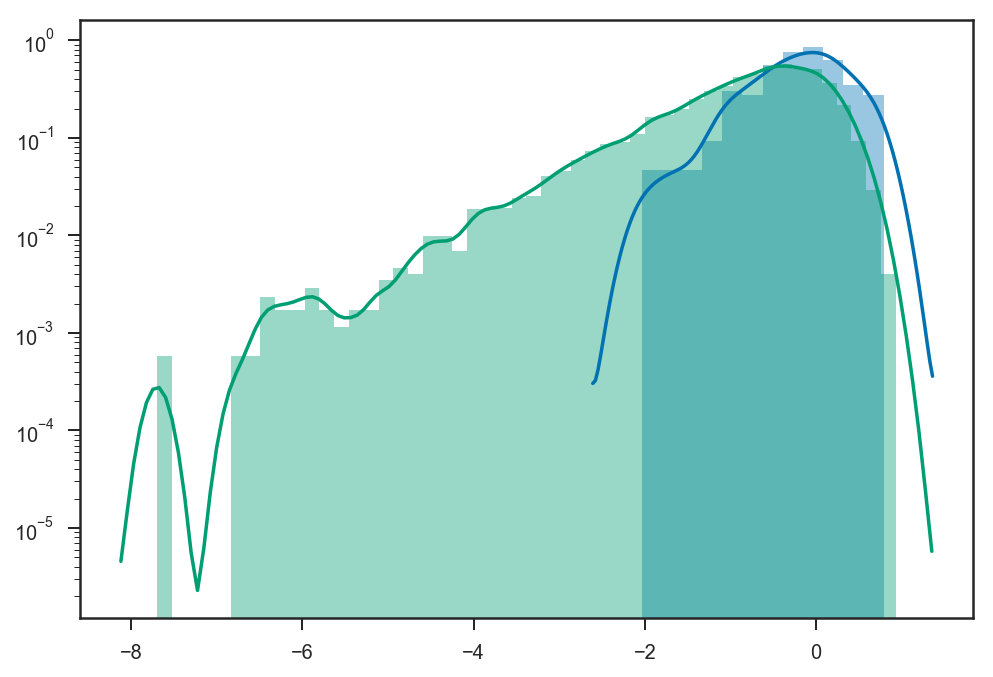

In [12]:
sns.distplot(log10(Ls))
sns.distplot(log10(draw_luminosity(-0.5, 1.0, size=10000)))
yscale('log')

Our Stan model is based on the following idea: consider adding parameters describing the $L$ and $z$ parameters for galaxies that don't pass the selection cut:
$$
\pi = \left[\prod_{k=1}^{N_\mathrm{obs}} p\left( L^\mathrm{obs}_k \mid L_k \right) \diff{N}{L}\left( L_k \right) \right] \times \left[\prod_{i = 1}^\infty p\left( L_i \mid \alpha, L_* \right)\right] \sum_{j=0}^\infty  \frac{N^j \prod_{i=1}^j P_\mathrm{ndet}\left( L_i \right)}{j!} \exp\left[ - N \right].
$$
Here $P_\mathrm{ndet}(L)$ is the probability that a galaxy with true Luminosity $L$ will not be detected:
$$
P_\mathrm{ndet}(L) = \int \dd L_\mathrm{obs} \, p\left( L_\mathrm{obs} \mid L \right) \left(1 - P_\mathrm{det}\left( L_\mathrm{obs} \right)\right)
$$

Integrating over all the $L_i$ parameters (an infinite number of them, but nevermind now!):
$$
\int \prod_{i=1}^\infty \dd L_i \, \pi = \left[\prod_{k=1}^{N_\mathrm{obs}} p\left( L^\mathrm{obs}_k \mid L_k \right) \diff{N}{L}\left( L_k \right) \right] \times \sum_{j=0}^\infty \frac{N^j \left\langle P_\mathrm{ndet} \right\rangle^j}{j!} \exp\left[ - N \right],
$$
where 
$$
\left\langle P_\mathrm{ndet} \right\rangle = \int \dd L \, \dd L_\mathrm{obs} p\left( L_\mathrm{obs} \mid L \right) p\left( L \mid \alpha, L_* \right) \left(1 - P_\mathrm{det}\left( L_\mathrm{obs} \right) \right)
$$
is the population-averaged non-detection probability.

Performing the sum, we see that the posterior, with the non-selected galaxies marginalised over becomes 
$$
\int \prod_{i=1}^\infty \dd L_i \, \pi = \left[\prod_{k=1}^{N_\mathrm{obs}} p\left( L^\mathrm{obs}_k \mid L_k \right) \diff{N}{L}\left( L_k \right) \right] \exp\left[ - N_\mathrm{det} \right],
$$
where 
$$
N_\mathrm{det} = N \left( 1 - \left\langle P_\mathrm{ndet} \right\rangle \right)
$$
is the expected number of detected galaxies in the survey.  This posterior is appropriate for analysing the *selected* galaxies in the survey.  In other words, by introducing the additional variables describing the non-detected population and then marginalising over them we *compute* the selection effects integrals automatically.  

The final trick employed in the attached Stan file is that (of course) we cannot actually introduce an infinite number of new parameters; instead, we cap the number of un-observed galaxies at significantly larger than the true number of expected un-observed galaxies, and sum over the finite number of possible un-observed galaxies.  One implementation detail: the posterior breaks down if any of the un-observed luminosities or redshifts are such that the galaxy would be detected with probability 1, so we have to put in an explicit initialiser than ensures these parameters are set appropriately.

In [14]:
model = pystan.StanModel(file='selection.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_4245a3709ee9c4964b9b227f6521ca84 NOW.


In [19]:
fit = model.sampling(data={'Nobs': len(Ls), 'Lobs': Ls, 'Nmax': 2000, 'zmax': 3, 'Fth': 1/(4*pi), 'Funcert': 0.05},
                     init=({'N':1000, 'alpha': -0.5, 'Lstar':1.0, 'Ltrue': Ls, 'Ltrue_unobs': 0.1*ones(2000), 'ztrue_unobs': 1.0*ones(2000)},)*4)

In [20]:
fit

Inference for Stan model: anon_model_4245a3709ee9c4964b9b227f6521ca84.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                    mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
N                 1935.2   44.88  77.74 1802.3 1866.0 1959.9 1990.6 2085.1      3   2.14
alpha              -0.12    0.12   0.18  -0.29  -0.25  -0.18  -0.02   0.27      2   8.61
Lstar                0.5    0.04   0.06   0.42   0.45   0.49   0.54    0.6      2   4.73
Ltrue[0]             1.9    0.03   0.09   1.76   1.83   1.89   1.95    2.1      7   1.39
Ltrue[1]            0.45  4.5e-3   0.02   0.41   0.43   0.45   0.46   0.49     20   1.27
Ltrue[2]             2.5    0.06   0.11   2.31   2.42   2.48   2.57   2.71      3   1.69
Ltrue[3]            1.57    0.02   0.07   1.45   1.52   1.57   1.61   1.71     12   1.49
Ltrue[4]            0.04  1.6e-3 2.7e-3   0.04   0.04   0.04   0.04   0.05      3    1.9
Ltrue[5]  

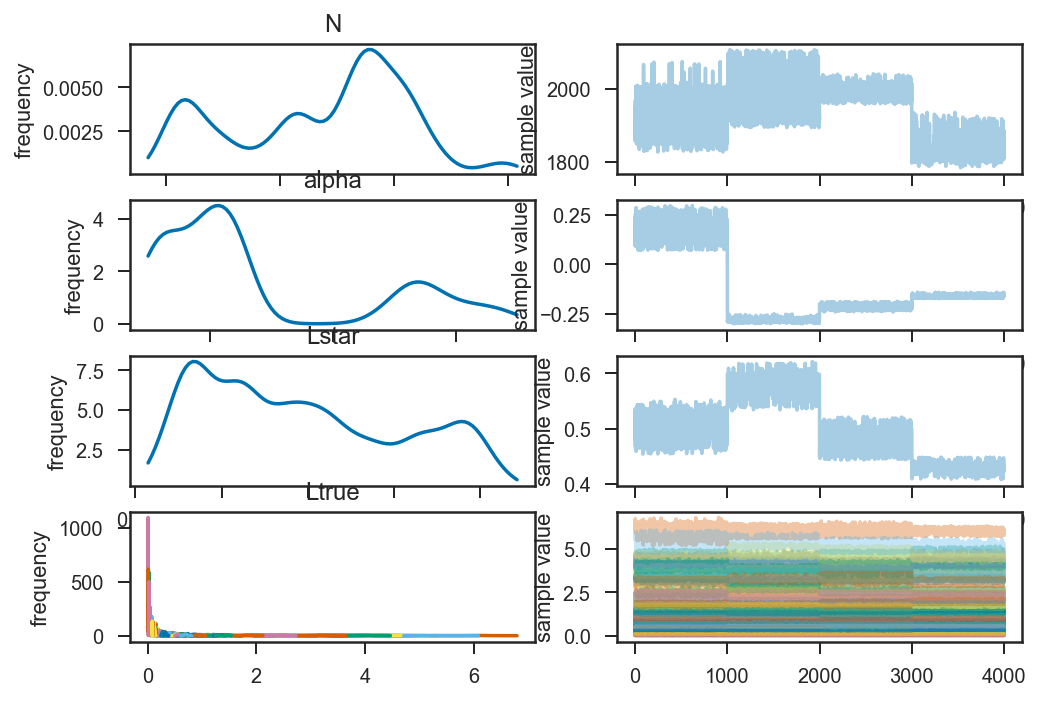

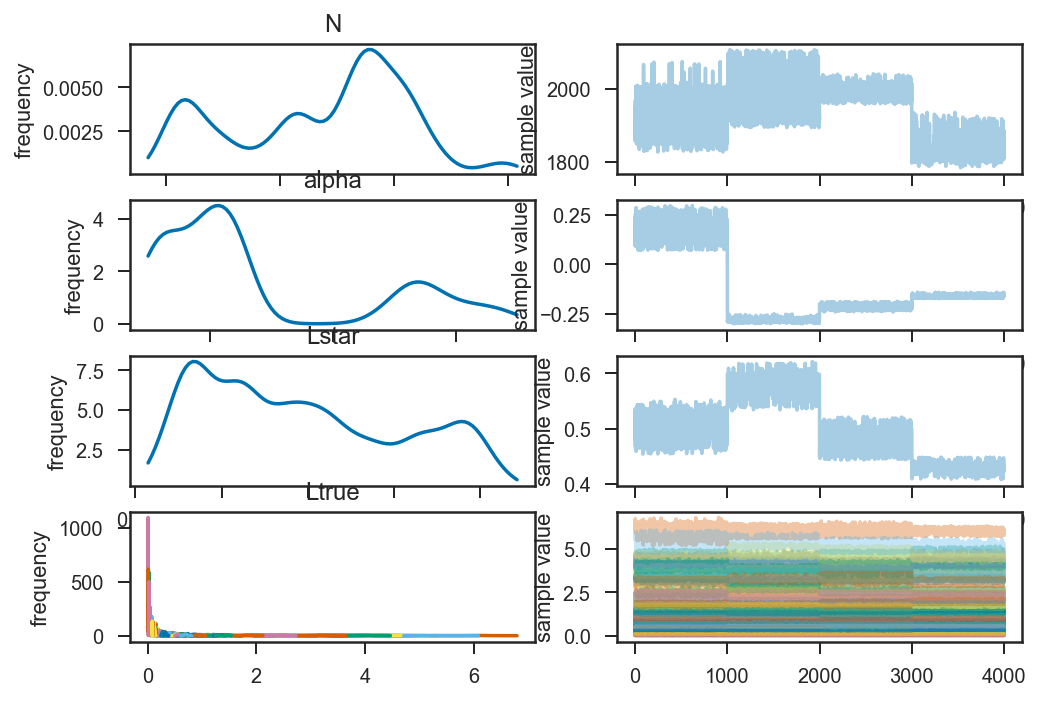

In [22]:
fit.plot(['N', 'alpha', 'Lstar', 'Ltrue'])

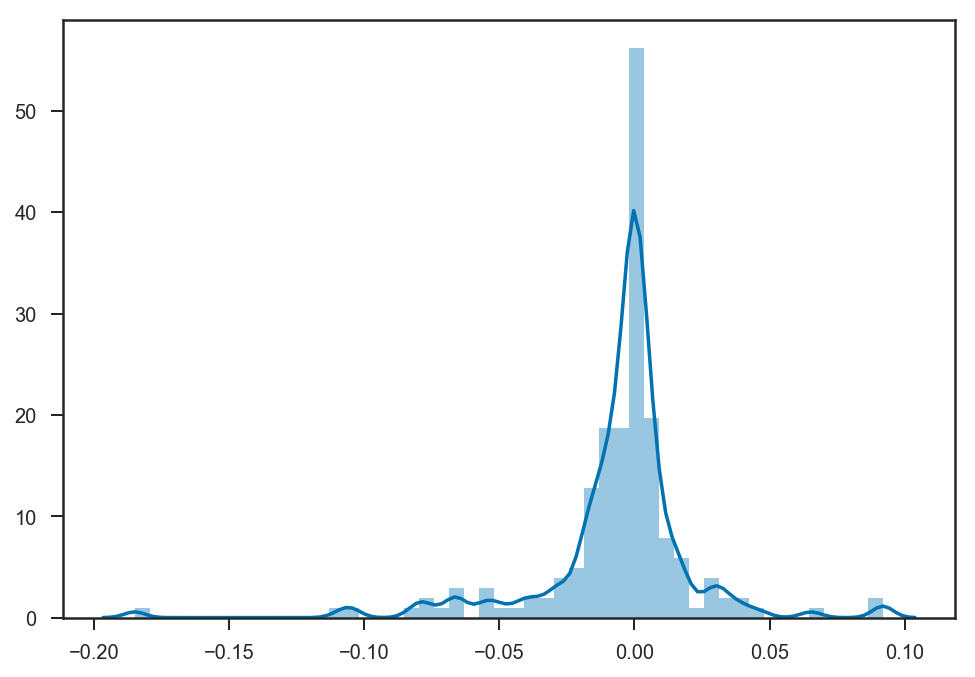

In [26]:
sns.distplot(mean(fit.extract(permuted=True)['Ltrue']-Ls, axis=0))